In [131]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
# Parameters for GBM
dt = 1/252
S_0 = 11510.46 #Price of SMI at 6 Aug 2024
inital_price = 11130.44
r = 0.01
Nsim = 1000
N = 258 #Number of business days from 6 Aug 2024 to 18 Aug 2025
sigma = 0.136 

In [133]:
def GBM(sigma, N,  S_0 , r = 0.01 , Nsim = 10000):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim,N])
    S[:,0] = S_0

    for i in range(Nsim):
        for j in range(N-1):
            Z = np.random.normal(0, 1)      
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
    return S

In [134]:
def GBM_AV(sigma, N,  S_0, r = 0.01 , Nsim = 10000):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim,N])
    S[:,0] = S_0

    for i in range(Nsim//2):
        for j in range(N-1):
            Z = np.random.normal(0, 1)      
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[2*i,j+1] = S[2*i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
            S[2*i+1,j+1] = S[2*i+1,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * -Z * np.sqrt(dt) )

    return S

In [146]:
#Payoff function for the derivative given a price path
def payoff(price_path, barrier_price = 6566.9596, initial_price = 11130.44):
    barrier_hit = min(price_path) <= barrier_price
    asset_final_price = price_path[-1]

    if barrier_hit:
        return 1000 * (asset_final_price / initial_price)
    else:
        return 1000 * max(1, 1 + 1.25 * (asset_final_price / initial_price - 1))

In [147]:
# Payoff for a given set of simulations
def payoff_sim(S, barrier_price = 6566.9596, initial_price = 11130.44):
    num_simulations = S.shape[0]
    payoff_values = np.zeros(num_simulations)
    for i in range(num_simulations):
        # Need to discount the payoff to present value
        payoff_values[i] = math.exp(-r*N*dt) * payoff(S[i,:], barrier_price, initial_price)
    return payoff_values

In [137]:
S = GBM(sigma, N, S_0)
S_AV = GBM_AV(sigma, N, S_0)


Text(0.5, 1.0, 'Stock price simulation using Geometric Brownian Motion')

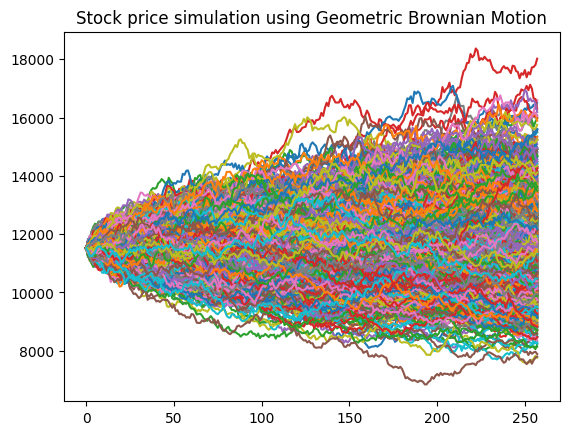

In [138]:
t = range(N)
for i in range(Nsim):
    plt.plot(t, S[i])
plt.title('Stock price simulation using Geometric Brownian Motion')

Text(0.5, 1.0, 'Stock price simulation using Geometric Brownian Motion with Antithetic Variates')

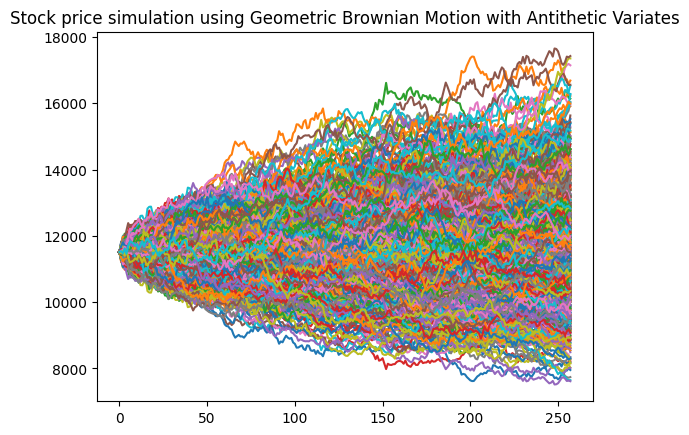

In [139]:
t = range(N)
for i in range(Nsim):
    plt.plot(t, S_AV[i])
plt.title('Stock price simulation using Geometric Brownian Motion with Antithetic Variates')

In [140]:
def gbm_SS(sigma, N, S_0, num_bins = 5, r = 0.01 , Nsim = 10000, barrier_price = 6566.9596):
    # Create a 2D array to store the stock prices for each simulation
    S = np.zeros([Nsim,N])
    S[:,0] = S_0

    for i in range(Nsim//num_bins):
        Z = np.random.normal(0, 1)
        for k in range(num_bins):
            S[num_bins*i+k,1] = S[num_bins*i+k,0] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * (Z+k)/num_bins * np.sqrt(dt) )

    for i in range(Nsim):   
        for j in range(1,N-1):
            Z = np.random.normal(0, 1)
            # Calculate the stock price at time t+1 using the Geometric Brownian Motion model with risk-free interet rate
            S[i,j+1] = S[i,j] * np.exp( (r - 0.5 * sigma ** 2) * dt + sigma * Z * np.sqrt(dt) )
    return S

In [141]:
S_SS = gbm_SS(sigma, N, S_0)

Text(0.5, 1.0, 'Stock price simulation using Geometric Brownian Motion with SS')

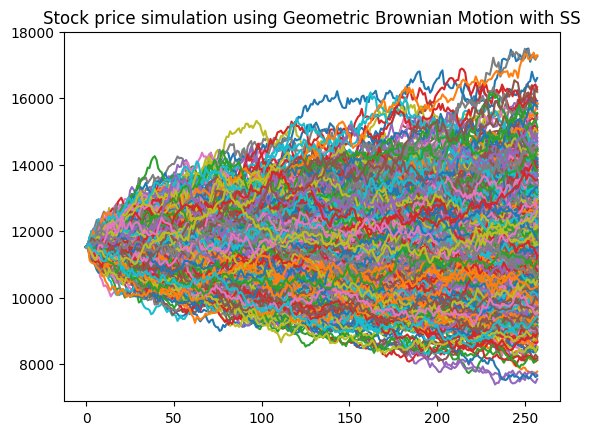

In [142]:

t = range(N)
for i in range(Nsim):
    plt.plot(t, S_SS[i])
plt.title('Stock price simulation using Geometric Brownian Motion with SS')

/tmp/ipykernel_24038/3339198346.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([S[:, -1], S_SS[:, -1], S_AV[:, -1], S_CV[:, -1]], labels=["Normal", "Stratified", "Antithetic", "ControlVariate"], showfliers=False)


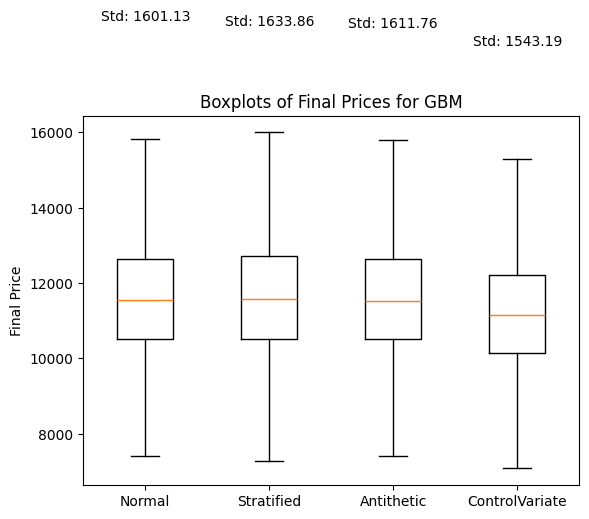

In [39]:
S_CV = np.load('gmb_control_variate_sim.npy')

# Calculate the volatility (standard deviation) for each set of final prices
volatility_normal = np.std(S[:, -1])
volatility_stratified = np.std(S_SS[:, -1])
volatility_antithetic = np.std(S_AV[:, -1])
volatility_control_variate = np.std(S_CV[:, -1])

# Create the boxplot
plt.boxplot([S[:, -1], S_SS[:, -1], S_AV[:, -1], S_CV[:, -1]], labels=["Normal", "Stratified", "Antithetic", "ControlVariate"], showfliers=False)
plt.ylabel("Final Price")
plt.title("Boxplots of Final Prices for GBM")

# Annotate the plot with the calculated volatility
plt.text(1, max(S[:, -1]), f"Std: {volatility_normal:.2f}", ha='center', va='bottom', fontsize=10)
plt.text(2, max(S_SS[:, -1]), f"Std: {volatility_stratified:.2f}", ha='center', va='bottom', fontsize=10)
plt.text(3, max(S_AV[:, -1]), f"Std: {volatility_antithetic:.2f}", ha='center', va='bottom', fontsize=10)
plt.text(4, max(S_CV[:, -1]), f"Std: {volatility_control_variate:.2f}", ha='center', va='bottom', fontsize=10)

plt.show()

In [143]:
derivative_price = payoff_sim(S)
derivative_price_AV = payoff_sim(S_AV)
derivative_price_SS = payoff_sim(S_SS)


In [144]:
print(derivative_price.mean(), derivative_price_AV.mean(), derivative_price_SS.mean())

1087.5823825027724 1090.9696978943045 1094.7316609671411
